In [9]:
#!pip install torch transformers nltk

# import nessaries libraries:
import nltk
nltk.download('punkt')

import string
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import os
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import pipeline
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import math
import re
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anitr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using device: cuda


## Data Preprocessing

In [5]:
# Load and Parse Data

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

# Set the pad_token to the eos_token and specify padding side
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'  # For decoder-only models like GPT-2

# Define the paths to the dataset files
lines_file = "dataset/movie_lines.txt"
conversations_file = "dataset/movie_conversations.txt"

# Function to clean dialogue text (lowercase, remove punctuation, remove stage directions)
def clean_text(text):
    """
    Clean the dialogue text: lowercase, remove punctuation, and stage directions.
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]|\(.*?\)', '', text)  # Remove stage directions (e.g., [laughs] or (looks away))
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Function to load and parse the movie lines
def load_lines(file_path):
    """
    Load and parse the movie lines from the dataset.
    Returns a dictionary mapping line IDs to text.
    """
    lines = {}
    # Open the file with the appropriate encoding to handle special characters
    with open(file_path, encoding='iso-8859-1') as f:
        for line in f:
            # Split each line into its components
            parts = line.strip().split(" +++$+++ ")
            if len(parts) == 5:
                line_id = parts[0]  # Unique identifier for the line
                text = clean_text(parts[4])     # The actual clean dialogue text
                lines[line_id] = text  # Store in a dictionary
    return lines

# Function to load and parse the movie conversations
def load_conversations(file_path):
    """
    Load and parse the movie conversations from the dataset.
    Returns a list of conversations, each conversation is a list of line IDs.
    """
    conversations = []
    # Open the file with the appropriate encoding
    with open(file_path, encoding='iso-8859-1') as f:
        for line in f:
            # Split each line into its components
            parts = line.strip().split(" +++$+++ ")
            if len(parts) == 4:
                # The fourth part contains the list of line IDs in a conversation
                line_ids = eval(parts[3])  # Convert the string representation of the list to an actual list
                conversations.append(line_ids)
    return conversations

# Function to extract dialogues based on the conversations and lines
def extract_dialogues(conversations, lines):
    """
    Extract the dialogues from the conversations using the line IDs.
    Returns a list of dialogues, each dialogue is a list of utterances.
    """
    dialogues = []
    for conv in conversations:
        conv_dialogues = []
        for line_id in conv:
            if line_id in lines:
                text = lines[line_id]
                if len(text.split()) > 2:  # Filter out short dialogues with 2 words or less
                    conv_dialogues.append(text)  # Append the cleaned dialogue text for each line ID
        if conv_dialogues:  # Only add conversations with valid dialogues
            dialogues.append(conv_dialogues)
    return dialogues

# Load the data
lines = load_lines(lines_file)
conversations = load_conversations(conversations_file)
dialogues = extract_dialogues(conversations, lines)

# Display sample dialogues for inspection
print("Sample Dialogues:")
for i in range(2):
    print(f"Conversation {i+1}: {dialogues[i]}")

Sample Dialogues:
Conversation 1: ['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again', 'well i thought wed start with pronunciation if thats okay with you', 'not the hacking and gagging and spitting part please', 'okay then how bout we try out some french cuisine saturday night']
Conversation 2: ['youre asking me out thats so cute whats your name again']


#### Explanation:
- The pad_token is set to the eos_token (<|endoftext|>) to handle padding.
- The padding side is set to 'left' because GPT-2 is a decoder-only model.
- Load the dataset files and parse them to extract dialogues.
- The load_lines function reads movie_lines.txt and stores each line's text with its unique ID.
- The load_conversations function reads movie_conversations.txt and extracts sequences of line IDs representing conversations.
- The extract_dialogues function links line IDs to their actual text to reconstruct the conversations.
- Data cleaning - text normalization (lowercasin and removing extra spaces), removing punctuation, handling stage directions, and filtering short dialogues.

### Exploratory Data Analysis

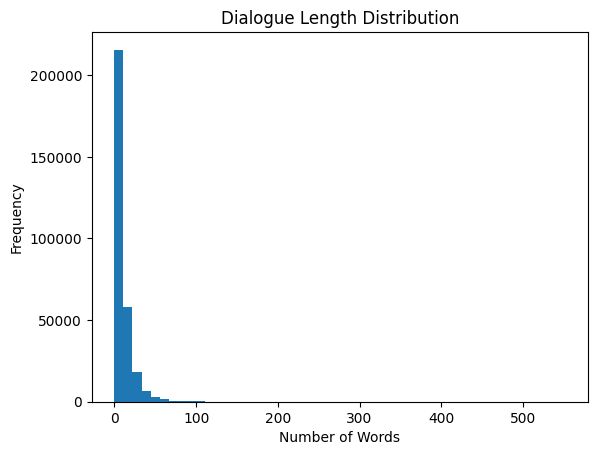

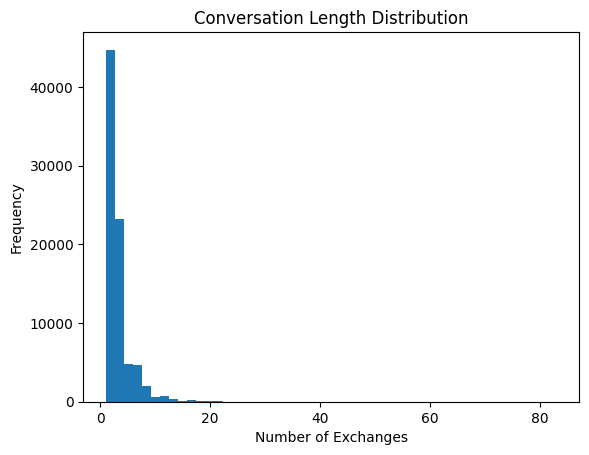

Top 20 most common words:
    Word  Frequency
0    you     127506
1      i     102122
2    the      98822
3     to      80464
4      a      70579
5     it      46990
6    and      45456
7     of      39266
8   that      35107
9     in      34011
10  what      31946
11    me      31705
12    is      29071
13  this      24382
14  dont      24227
15   for      23329
16    do      22623
17    im      22272
18  know      21497
19  have      21452


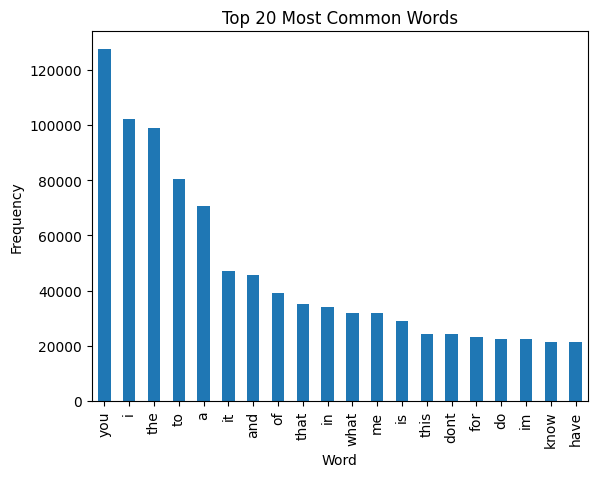

In [22]:
# Analyze the length distribution of the dialogues
def plot_dialogue_length_distribution(dialogues):
    """
    Plot the distribution of dialogue lengths (in number of words).
    """
    dialogue_lengths = [len(dialogue.split()) for dialogue in lines.values()]
    plt.hist(dialogue_lengths, bins=50)
    plt.title('Dialogue Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

# Analyze the conversation structure (number of exchanges in each conversation)
def plot_conversation_structure(conversations):
    """
    Plot the distribution of the number of exchanges per conversation.
    """
    conversation_lengths = [len(conv) for conv in dialogues]
    plt.hist(conversation_lengths, bins=50)
    plt.title('Conversation Length Distribution')
    plt.xlabel('Number of Exchanges')
    plt.ylabel('Frequency')
    plt.show()

# Word frequency analysis
def analyze_word_frequency(lines):
    """
    Analyze the word frequency in the entire dataset.
    """
    all_words = " ".join(lines.values()).split()
    word_freq = Counter(all_words)
    
    # Create a table of the 20 most common words
    word_freq_table = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])
    print("Top 20 most common words:")
    print(word_freq_table)
    
    # Plot the top 20 most frequent words
    word_freq_table.plot(kind='bar', x='Word', y='Frequency', legend=False)
    plt.title('Top 20 Most Common Words')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.show()

# Run EDA
plot_dialogue_length_distribution(lines)  # Dialogue length distribution
plot_conversation_structure(dialogues)  # Conversation length structure
analyze_word_frequency(lines)  # Word frequency analysis

### Prepare Data for Training

In [21]:
# Initialize the sentiment analyzer
sentiment_analyzer = pipeline("sentiment-analysis", device=0 if torch.cuda.is_available() else -1)

# Set the maximum number of previous exchanges to use as context
max_history = 5
max_length = 512  # GPT-2 model limit

# Function to batch process sentiment analysis
def analyze_sentiment_in_batches(replies, batch_size=32):
    sentiments = []
    for i in range(0, len(replies), batch_size):
        batch_replies = replies[i:i + batch_size]
        batch_sentiments = sentiment_analyzer(batch_replies)  # Analyze sentiment for a batch
        sentiments.extend([result['label'] for result in batch_sentiments])
    return sentiments

# Function to build input-target pairs from dialogues with batch sentiment analysis
def build_inputs_targets(dialogues, tokenizer, max_length=512, batch_size=32):
    """
    Build input-target pairs for training using batch processing.
    Each input consists of a context (history of utterances) and the target is the next reply.
    """
    inputs = []
    speaker_labels = ["<speaker1>", "<speaker2>"]  # Alternating speaker labels
    
    for conv in tqdm(dialogues, desc="Processing Dialogues"):
        for i in range(1, len(conv)):
            # Use up to max_history previous exchanges as context
            history = conv[max(0, i - max_history):i]
            reply = conv[i]  # The current reply

            # Truncate the reply to avoid exceeding the model's input limit
            truncated_reply = reply[:max_length]

            # Apply speaker labels to history
            labeled_history = [f"{speaker_labels[j % 2]} {utterance}" for j, utterance in enumerate(history)]

            # Detect sentiment for the reply in batch
            batch_sentiments = analyze_sentiment_in_batches([truncated_reply], batch_size=1)
            sentiment = batch_sentiments[0]

            # Add sentiment to the input text
            labeled_history = [f"<sentiment:{sentiment}> " + utt for utt in labeled_history]
            input_text = "<|endoftext|>".join(labeled_history) + f"<|endoftext|><sentiment:{sentiment}> {truncated_reply}<|endoftext|>"

            # Tokenize the input and ensure truncation and padding
            encoded_input = tokenizer.encode(
                input_text,
                add_special_tokens=False,
                max_length=max_length,  # Ensure input length doesn't exceed model's limit
                truncation=True
            )

            inputs.append(torch.tensor(encoded_input))

    return inputs

# Build the dataset with batch processing
data = build_inputs_targets(dialogues, tokenizer, batch_size=32)

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move data to the appropriate device (GPU if available)
encoded_data = [tensor.to(device) for tensor in data]

# Display sample encoded data
print("\nSample Encoded Data:")
for i in range(min(2, len(encoded_data))):
    print(f"Encoded Sample {i+1}: {encoded_data[i][:10]}... (length: {len(encoded_data[i])})")




No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Processing Dialogues: 100%|██████████| 81652/81652 [19:51<00:00, 68.50it/s]   


Using device: cuda

Sample Encoded Data:
Encoded Sample 1: tensor([   27, 34086,  3681,    25,    45,  7156, 37045,    29,  1279,  4125],
       device='cuda:0')... (length: 63)
Encoded Sample 2: tensor([   27, 34086,  3681,    25, 37997,  2043,  9306,    29,  1279,  4125],
       device='cuda:0')... (length: 87)


- Prepare the data by creating input-target pairs, where the input is the conversation history and the target is the reply.
- The encode_data function tokenizes and encodes the combined text using the GPT-2 tokenizer.
- Ensure that the input sequences are truncated to a maximum length to fit the model's requirements.
- Feature engineering - speaker labels, sentiment analysis, and sequence length control added. 

### Create Dataset and DataLoader

In [5]:
# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Custom dataset class for our chatbot data
class ChatDataset(Dataset):
    def __init__(self, encoded_data):
        self.data = encoded_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Collate function to pad sequences within a batch and create attention masks and labels
def collate_fn(batch):
    input_ids = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=tokenizer.pad_token_id
    ).to(device)  # Move to device (GPU or CPU)
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)  # Move to device
    labels = input_ids.clone().to(device)  # Move to device
    labels[input_ids == tokenizer.pad_token_id] = -100
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# To use a smaller subset of the data for faster training
subset_size = 30000  # Adjust based on our computational resources
encoded_data = encoded_data[:subset_size]

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

# First, split the data into training and test sets (80% train, 20% test)
train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

# Then, split the training data into training and validation sets (80% train, 20% val)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Verify the sizes of the splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Create dataset instances
train_dataset = ChatDataset(train_data)
val_dataset = ChatDataset(val_data)
test_dataset = ChatDataset(test_data)

# Define batch size
batch_size = 4  # Adjust based on available resources

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Using device: cuda
Training set size: 19200
Validation set size: 4800
Test set size: 6000


- Create a custom ChatDataset class to handle our data.
- The collate_fn function pads sequences in a batch to the same length.
- Use DataLoader to efficiently load data during training.
- A subset of the data is used to speed up training when resources are limited

## Model Design and Initialization

In [6]:
# Specify the model name; use a smaller model if resources are limited
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the GPT-2 model
model_name = 'gpt2-medium'  # We can use 'gpt2-medium' if using a GPU

model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)

# Display model size
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {count_parameters(model):,}")

Total Parameters: 354,823,168


Initialize the pre-trained GPT-2 model and move it to the appropriate device.

Load the GPT-2 model (chose 'gpt2-medium') and set up the device (CPU).

### Define Evaluation Metrics and Implement Evaluation Metrics

In [7]:
# Fine-Tuning the Model
epochs = 3  # Number of training epochs
optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_steps)


# Function to evaluate the model on a validation set
def evaluate(model, dataloader):
    """
    Evaluate the model on the validation set.
    Computes perplexity as the evaluation metric.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_tokens = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            # Forward pass with labels to compute loss
            outputs = model(**batch)
            loss = outputs.loss  # Mean loss per token in batch
            num_tokens = batch['attention_mask'].sum().item()
            # Accumulate loss and token counts
            total_loss += loss.item() * num_tokens  # Total loss over all tokens in batch
            total_tokens += num_tokens
    # Calculate perplexity
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return perplexity


# Function to calculate the BLEU score on the validation set
def calculate_bleu(model, dataloader, tokenizer):
    """
    Calculate the average BLEU score on the validation set.
    """
    model.eval()  # Set the model to evaluation mode
    bleu_scores = []
    smooth_fn = SmoothingFunction().method1  # Smoothing function for BLEU score
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating BLEU"):
            batch = {k: v.to(device) for k, v in batch.items()}
            # Generate predictions
            outputs = model.generate(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                max_length=batch['input_ids'].shape[1] + 50,
                pad_token_id=tokenizer.pad_token_id,
                do_sample=False,
            )
            for i in range(batch['input_ids'].size(0)):
                # Decode the reference and hypothesis texts
                input_len = (batch['input_ids'][i] != tokenizer.pad_token_id).sum().item()
                reference_ids = batch['input_ids'][i][input_len:].tolist()
                hypothesis_ids = outputs[i][input_len:].tolist()
                reference = tokenizer.decode(reference_ids, skip_special_tokens=True)
                hypothesis = tokenizer.decode(hypothesis_ids, skip_special_tokens=True)
                # Tokenize the texts
                reference_tokens = nltk.word_tokenize(reference)
                hypothesis_tokens = nltk.word_tokenize(hypothesis)
                # Compute BLEU score
                bleu = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)
                bleu_scores.append(bleu)
    # Calculate average BLEU score
    average_bleu = sum(bleu_scores) / len(bleu_scores)
    return average_bleu

- The evaluate function computes the perplexity of the model on the validation set.
- Perplexity is a measure of how well the model predicts the sample; lower values indicate better performance.
- Use torch.no_grad() to disable gradient computation during evaluation for efficiency.

- The calculate_bleu function evaluates the model's predictions against the ground truth using the BLEU score.
- BLEU score measures the similarity between the generated text and reference text.
- Smoothing is applied to handle cases where the hypothesis and reference have few overlapping n-grams.

### Training Loop 

In [8]:
import torch
torch.cuda.empty_cache()


In [9]:
# Initialize variables for tracking best performance
best_val_perplexity = float('inf')
best_model_state = None

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Training loop
for epoch in range(epochs):
    total_train_loss = 0
    total_train_tokens = 0  # Initialize total_train_tokens
    model.train()  # Set the model to training mode
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()  # Reset gradients
        # Forward pass with labels to compute loss
        outputs = model(**batch)
        loss = outputs.loss  # Mean loss per token
        num_tokens = batch['attention_mask'].sum().item()
        # Backward pass to compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        # Update learning rate
        scheduler.step()
        # Accumulate training loss
        total_train_loss += loss.item() * num_tokens
        total_train_tokens += num_tokens
    # Calculate average training loss
    avg_train_loss = total_train_loss / total_train_tokens
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss:.4f}")
    # Evaluate on validation set
    val_perplexity = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}, Validation Perplexity: {val_perplexity:.4f}")
    if val_perplexity < best_val_perplexity:
        best_val_perplexity = val_perplexity
        best_model_state = model.state_dict()
        print(f"Validation perplexity improved; model saved.")
    else:
        print(f"No improvement in validation perplexity.")

# Load the best model state before testing
if best_model_state is not None:
    model.load_state_dict(best_model_state)
else:
    print("No improvement during training; using last epoch model.")

# Save the best model
model_save_path = 'fine_tuned_gpt2_medium.pt'
torch.save(model.state_dict(), model_save_path)
print(f"Best model saved to {model_save_path}")

Using device: cuda


Training Epoch 1: 100%|██████████| 4800/4800 [13:45<00:00,  5.81it/s]


Epoch 1, Average Training Loss: 3.1258


Evaluating: 100%|██████████| 1200/1200 [00:50<00:00, 23.64it/s]


Epoch 1, Validation Perplexity: 16.1776
Validation perplexity improved; model saved.


Training Epoch 2: 100%|██████████| 4800/4800 [13:44<00:00,  5.82it/s]


Epoch 2, Average Training Loss: 2.5341


Evaluating: 100%|██████████| 1200/1200 [00:51<00:00, 23.52it/s]


Epoch 2, Validation Perplexity: 12.4245
Validation perplexity improved; model saved.


Training Epoch 3: 100%|██████████| 4800/4800 [13:57<00:00,  5.73it/s]


Epoch 3, Average Training Loss: 2.1949


Evaluating: 100%|██████████| 1200/1200 [00:51<00:00, 23.39it/s]


Epoch 3, Validation Perplexity: 11.4023
Validation perplexity improved; model saved.
Best model saved to fine_tuned_gpt2_medium.pt


- Train the model using the AdamW optimizer and a linear learning rate scheduler.
- The training loop iterates over epochs and batches, computing loss, performing backpropagation, and updating model parameters.
- After each epoch, evaluate the model on the validation set and compute perplexity.
- The trained model is saved to a file to avoid retraining in the future.

### Load the trained model

In [10]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the trained model
model_save_path = 'fine_tuned_gpt2_medium.pt'  # Define the model path here

try:
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print("Model loaded successfully!")
except RuntimeError as e:
    print(f"Error loading model state_dict: {e}")
    print("Please ensure that the model architecture matches the saved model weights.")

# Evaluate the final model on the test set
test_perplexity = evaluate(model, test_loader)
print(f"Final Test Perplexity: {test_perplexity:.4f}")

# Calculate BLEU score on the validation set
bleu_score = calculate_bleu(model, val_loader, tokenizer)
print(f"Validation BLEU Score: {bleu_score:.4f}")

Using device: cuda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Model loaded successfully!


Evaluating: 100%|██████████| 1500/1500 [01:03<00:00, 23.47it/s]


Final Test Perplexity: 11.5412


Calculating BLEU: 100%|██████████| 1200/1200 [28:03<00:00,  1.40s/it]

Validation BLEU Score: 0.0123


- Load the saved model weights into the model architecture.
- The model is set to evaluation mode to disable dropout and other training-specific layers.
- This allows us to use the trained model for generating responses.

## Interaction with the Chatbot

In [11]:
# Implement Content Filtering
import re

# List of disallowed words or phrases to filter out
disallowed_words = [
    # Offensive Language
    r'self_harm', r'suicide', r'death', r'kill',
    # Profanity (replace with actual words or leave as *)
    #r'\b(f**k|s**t|b***h|d**n|a**hole|c**t|sl*t|pr*ck|b**tard)\b',
    # Slurs or Hate Speech 
    #r'\b(racial_slur1|racial_slur2|homophobic_slur1|homophobic_slur2|gender_slur|ethnic_slur|religious_slur)\b',  
    # Explicit Sexual Content
    r'\b(porn|nude|sex|explicit|xxx|erotic|fetish|incest|rape|molest)\b',
    # Spam or Malicious Content
    #r'\b(spam|phishing|malware|virus|adware|trojan|scam|fraud)\b',
    # Violence or Graphic Content
    r'\b(assault|gun|shooting|bomb|explosion|attack|blood|mutilation|massacre)\b',
    # Misinformation and Conspiracy Theories
    #r'\b(fake_news|hoax|conspiracy|anti_vax|flat_earth|election_fraud)\b',
    # Harmful Behavior or Self-Harm
    r'\b(cutting|eating_disorder|anorexia|bulimia|starving|addiction)\b',
]

# Escape special regex characters and compile the pattern
pattern = re.compile(r'\b(' + '|'.join([re.escape(word) for word in disallowed_words]) + r')\b', re.IGNORECASE)

def contains_disallowed_content(text):
    return bool(pattern.search(text))

- Define patterns for disallowed content to prevent the chatbot from generating inappropriate responses.
- The contains_disallowed_content function checks if the generated text contains any disallowed words or phrases.

### Chatbot Class Implementation

In [12]:
class Chatbot:
    def __init__(self, model, tokenizer, max_history=4):
        self.model = model  # The language generation model
        self.tokenizer = tokenizer  # Tokenizer to encode/decode text
        self.max_history = max_history  # Number of previous exchanges to consider
        self.chat_history = []  # Stores the conversation history
        self.device = device  # Ensure device is set
        # Set pad_token to eos_token for models like GPT-2 that do not have a pad_token
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def reset_history(self):
        self.chat_history = []

    def get_response(self, user_input):
        # Detect inappropriate or harmful content
        if contains_disallowed_content(user_input):
            return "I'm sorry, but I cannot assist with that request."
            
        self.chat_history.append(user_input)
        # Keep only the last max_history exchanges
        history = self.chat_history[-self.max_history:]
        # Combine the history into a single input string
        input_text = "<|endoftext|>".join(history) + "<|endoftext|>"
        
        # Encode the input text with truncation and padding
        encoding = self.tokenizer(
            input_text,
            return_tensors='pt',
            max_length=512,  # Truncate if necessary
            truncation=True,
            padding=True
        )
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        # Generate a response
        output = self.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=50,  # Generate up to 50 new tokens
            pad_token_id=self.tokenizer.pad_token_id,
            do_sample=True,  # Use sampling for more varied responses
            top_p=0.92,      # Nucleus sampling parameter
            top_k=40,        # Top-k sampling parameter
            temperature=0.8, # Sampling temperature
            eos_token_id=self.tokenizer.eos_token_id,
            num_return_sequences=1,  # Generate one response at a time
            repetition_penalty=1.3,  # Penalize repetition for better response diversity
            no_repeat_ngram_size=3   # Prevent repetition of n-grams
        )
        # Extract the generated tokens beyond the input length
        generated_tokens = output[0][input_ids.size(-1):]
        # Decode the generated tokens to text
        reply = self.tokenizer.decode(generated_tokens, skip_special_tokens=True)
        # Apply content filtering
        if contains_disallowed_content(reply):
            reply = "I'm sorry, but I can't assist with that request."
            
        self.chat_history.append(reply)
        return reply.strip()

- The Chatbot class encapsulates the chatbot's functionality.
- It maintains a conversation history to provide context for multi-turn conversations.
- The get_response method generates a response using the model and applies content filtering.
- Sampling parameters (top_p, top_k, temperature) control the diversity of the generated responses.

### Interact with the Chatbot via Console

- Create an instance of the Chatbot class.
- A loop allows the user to interact with the chatbot via the console.
- The conversation continues until the user types an exit command.

In [16]:
# Instantiate the chatbot
chatbot = Chatbot(model, tokenizer)

print("Bot: Hello! How can I assist you today?")

# Manually specify user inputs in the notebook for each step
user_input = "How was your day?"  # Example input
print(f"You: {user_input}")
response = chatbot.get_response(user_input)
print(f"Bot: {response}")

Bot: Hello! How can I assist you today?
You: How was your day?
Bot: Excellent. Very professional and easy going, too--the kind of guy you need on a rainy night to keep things running smoothly in the city center or backcountry...a man who never lets his guard down.  What did he do for us today
